# Neural Networks Final Project -- Jeopardy Model

In [1]:
# Run this block to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import scipy.signal
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## set up / data pre-processing

In [34]:
data_df = pd.read_csv('JEOPARDY_CSV.csv')

print(data_df.shape)
data_df.head()

(216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [35]:
# FOR DEBUGGING
data_df = data_df.iloc[:1000,:]

### polish & remove outlier data 

In [36]:
data_df = data_df[data_df[' Value'].notnull()] # remove null values 

def extract_val(x):
    x = x.replace(',', '')
    x = x.replace('$', '')
    return int(x)

values = data_df[' Value'].apply(extract_val) # converting value strings to ints
data_df[' Value'] = values

data_df = data_df[data_df[' Value'] <= 2000] # removing data with values over 2000

data_df[' Question'] = data_df[' Question'].str.lower() # no repeat characters
print(data_df.shape)
data_df

(973, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"for the last 8 years of his life, galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,no. 2: 1912 olympian; football star at carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,the city of yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"in 1963, live on ""the art linkletter show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"signer of the dec. of indep., framer of the co...",John Adams
...,...,...,...,...,...,...,...
995,3619,2000-05-04,Double Jeopardy!,MR. OR MS. WILLIAMS,800,the aquatic mrs. fernando lamas,Esther Williams
996,3619,2000-05-04,Double Jeopardy!,AIN'T THAT AMERICA,500,in 1886 a pharmacist in this southern state be...,Georgia
997,3619,2000-05-04,Double Jeopardy!,PHYSICAL SCIENCE,1000,stoichiometry is defined as the study of the q...,Chemical reactions
998,3619,2000-05-04,Double Jeopardy!,INITIAL T.V.,1000,"organization that employed alexander waverly, ...",U.N.C.L.E. (United Network Command for Law and...


## make vocab dictionary

In [ ]:
chars = set() 
for question in data_df[' Question']: 
    chars.update(question)

possible_vals = sorted(set(data_df[ ' Value']))

# create mappings
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

print(char_to_idx)
# remove newlines!
char_to_idx['\n'] = char_to_idx[' ']

vocab_size = len(chars)

# printing some stuff
print("Characters:", chars)
print("Number of unique characters:", vocab_size)
print("All possible values:", possible_vals)

data_df[' Question'] = data_df[' Question'].apply(lambda x: [char_to_idx[ch] for ch in x]) # converting string to int array

## make train/test split

In [18]:
seed = 42 
train_df = data_df.sample(frac=0.8, random_state=seed)
test_df = data_df.drop(train_df.index)

In [19]:
from torch.nn.utils.rnn import pad_sequence

train_labels = torch.tensor([possible_vals.index(x) for x in train_df[' Value'].tolist()]) # converting values to position in possible values 
train_questions = [torch.tensor(q) for q in train_df[' Question']]
train_questions_padded = pad_sequence(train_questions, batch_first=False, padding_value=44) # char_to_idx[' '] = 44

train_dataset = torch.utils.data.TensorDataset(torch.transpose(train_questions_padded, 0, 1), train_labels) # TODO: is transposing ok...


test_labels = torch.tensor([possible_vals.index(x) for x in test_df[' Value'].tolist()])
test_questions = [torch.tensor(q) for q in test_df[' Question']]
test_questions_padded = pad_sequence(test_questions, batch_first=False, padding_value=44)

test_dataset = torch.utils.data.TensorDataset(torch.transpose(test_questions_padded, 0, 1), test_labels)

In [9]:
print(possible_vals)

[100, 200, 300, 400, 500, 600, 800, 1000, 1100, 1200, 1500, 1600, 1800, 2000]


In [20]:
# FROM HW 2
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = train_df.shape[0]
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset)

## model

In [21]:
class JeopardyModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(JeopardyModel, self).__init__()
        self.embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size) 
        self.lstm = torch.nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.output_layer = torch.nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, x, hidden_state):
        x_vector = self.embed(x)
        lstm_outputs, h_n = self.lstm(x_vector, hidden_state)
        outputs = self.output_layer(lstm_outputs[:, -1, :])
        return outputs, h_n 

## training 

In [22]:
hidden_size = 256

model = JeopardyModel(input_size=vocab_size, output_size=len(possible_vals), hidden_size=hidden_size)
loss_func = torch.nn.CrossEntropyLoss() # torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
nepoch = 100

In [11]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    model = JeopardyModel(input_size=vocab_size, output_size=len(possible_vals), hidden_size=hidden_size)
    h = torch.zeros((2,178,hidden_size)) 
    c = torch.zeros((2,178,hidden_size))
    outputs, _ = model(images, (h,c))
    print(outputs.shape)
    break

torch.Size([64, 603]) torch.Size([64])


NameError: name 'JeopardyModel' is not defined

In [12]:
# FROM HW 2
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0

            h = torch.zeros((2, 603,hidden_size))    #TODO: does this make sense ...
            c = torch.zeros((2, 603,hidden_size))
            for inputs, labels in train_loader:
                # print("input train")
                optimizer.zero_grad()
                outputs, (h,c) = model(inputs , (h.detach(), c.detach()))
                # print("o", outputs)
                # print("l", labels)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print(loss.item())
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0

                h = torch.zeros((2, 603,hidden_size))    #TODO: do we start w clean slate for val?
                c = torch.zeros((2, 603,hidden_size))
                for inputs, labels in val_loader:
                    outputs, (h,c) = model(inputs , (h.detach(), c.detach()))
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [13]:
train_network(model, train_loader, val_loader, loss_func, optimizer, nepoch)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.41035
   Val loss: 2.38476

EPOCH 1
 Train loss: 2.31844
   Val loss: 2.55022

EPOCH 2
 Train loss: 2.32406
   Val loss: 2.42791

EPOCH 3
 Train loss: 2.31747
   Val loss: 2.25368

EPOCH 4
 Train loss: 2.30841
   Val loss: 2.35299

EPOCH 5
 Train loss: 2.30777
   Val loss: 2.39587

EPOCH 6
 Train loss: 2.30250
   Val loss: 2.38061

EPOCH 7
 Train loss: 2.30612
   Val loss: 2.36583

EPOCH 8
 Train loss: 2.30169
   Val loss: 2.31471

EPOCH 9
 Train loss: 2.30480
   Val loss: 2.63737

EPOCH 10
 Train loss: 2.30361
   Val loss: 2.51195

EPOCH 11
 Train loss: 2.30438
   Val loss: 2.39088

EPOCH 12
 Train loss: 2.30159
   Val loss: 2.40195

EPOCH 13
 Train loss: 2.30571
   Val loss: 2.49824

EPOCH 14
 Train loss: 2.29853
   Val loss: 2.57270

EPOCH 15
 Train loss: 2.30258
   Val loss: 2.44771

EPOCH 16
 Train loss: 2.29992
   Val loss: 2.50228

EPOCH 17
 Train loss: 2.30108
   Val loss: 2.33484

EPOCH 18
 Train loss: 2.30107
   Val loss: 2.33634

EPOCH 19
 Train loss: 

## test

In [14]:
# def test_network(model, test_loader, mode):
#     true, pred = [], []
#     total = correct = 0
#     with torch.no_grad():
#         for inputs, labels  in test_loader:
#             h = torch.zeros((2, 409,hidden_size))    
#             c = torch.zeros((2, 409,hidden_size))

#             outputs, (h,c) = model(inputs, (h.detach(), c.detach()))
#             print("o", outputs)
#             print("l", labels)
            
#             total += labels.size(0)
#             correct += (outputs - labels <= 50).sum().item()

#             true.append(labels)
#             pred.append(outputs)
#     acc = (100 * correct / total)
#     print('%s accuracy: %0.3f' % (mode, acc))
#     true = np.concatenate(true)
#     pred = np.concatenate(pred)
#     return acc, true, pred
def test_network(model, test_loader, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        for inputs, labels  in test_loader:
            h = torch.zeros((2, 409,hidden_size))    
            c = torch.zeros((2, 409,hidden_size))

            outputs, _ = model(inputs, (h.detach(), c.detach()))
            print(outputs)
            predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [15]:
acc, true, pred = test_network(model, test_loader, "Model")
acc, true, pred

tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016, -1.3518,  0.0193]])
tensor([[-0.1114,  0.5606, -0.1194,  0.7608, -0.1282,  0.2221,  0.5697,  0.2996,
         -3.6643,  0.0169, -1.5056, -0.1016

(21.53846153846154,
 array([ 1,  1,  5,  5,  6,  6,  7,  3,  3,  6,  9, 11, 13,  1,  3,  3,  5,
         7,  3,  3,  6,  6,  9,  9, 11, 11, 13,  1,  2,  3,  3,  4,  5,  6,
         7,  6,  7,  0,  3,  3,  3,  1,  1,  3,  3,  5,  5,  6,  1,  3,  5,
         5,  5,  6,  6,  6,  7,  9,  9, 13,  3,  6,  7,  7,  6, 11, 11, 13,
        13,  3,  4,  1,  1,  3,  3,  3,  5,  5,  8,  6,  7,  1,  3,  6,  3,
        13, 13, 13, 13,  1,  1,  3,  5,  5,  5,  5,  7,  3,  3,  3,  6,  9,
         9, 11, 11,  0,  1,  3,  4,  1,  3,  3,  5,  5,  5, 13,  5,  5,  6,
         7,  7,  1,  5,  7,  6,  6,  1,  1,  2, 10,  4,  4,  3,  5,  6,  6,
         7,  1,  1,  1,  3,  3,  7,  7,  3,  3,  3,  3,  6,  9,  9, 11, 13,
         3,  3,  5,  5,  5,  5,  6,  6,  7,  7,  6,  6, 11, 11,  1,  1,  3,
         3,  7,  5,  7,  7,  3,  6, 11, 11, 13, 13,  0,  0,  1,  2,  1,  3,
        13,  7,  4,  1,  1,  3,  6,  4], dtype=int64),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3

In [16]:
import joblib
joblib.dump(model, "nn_final_model.jbl")

['nn_final_model.jbl']

In [23]:
import joblib
model = joblib.load("nn_final_model.jbl")

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(d_model, len(possible_vals))
        
    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = tgt.unsqueeze(1).unsqueeze(-1).expand(-1, src.size(1), src.size(2))
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

In [45]:
vocab_size = len(chars)  # Example vocab size, replace with actual vocab size
d_model = vocab_size # 32  # Dimension of the model
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of encoder layers
num_decoder_layers = 2  # Number of decoder layers
dim_feedforward = 128  # Dimension of the feedforward network
dropout = 0.1  # Dropout rate

model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)

RuntimeError: The expanded size of the tensor (30) must match the existing size (31) at non-singleton dimension 1.  Target sizes: [5000, 30].  Tensor sizes: [5000, 31]

In [24]:
category_correct_dict = {}
category_total_dict = {}

def category_test_network(model, test_loader, test_df, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        index = 0
        for inputs, labels  in test_loader:
            #print(inputs)
            h = torch.zeros((2, 409,hidden_size))    
            c = torch.zeros((2, 409,hidden_size))

            outputs, _ = model(inputs, (h.detach(), c.detach()))
            # print(outputs)
            # print(labels.size(0))
            # test_df['Category']
            category = test_df.iloc[index][' Category']
            predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            index += 1

            if category not in category_correct_dict:
                category_correct_dict[category] = 0
                category_total_dict[category] = 0

            category_correct_dict[category] += (predicted == labels).sum().item()
            category_total_dict[category] += 1

            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return category_correct_dict, category_total_dict

In [25]:
category_value = test_df.iloc[0][' Category']
print(category_value)
(category_correct_dict, category_total_dict) = category_test_network(model, test_loader, test_df, 'Test')

ESPN's TOP 10 ALL-TIME ATHLETES
Test accuracy: 21.538


In [26]:
category_acc = {}
for category in category_correct_dict:
    category_acc[category] = float(category_correct_dict[category])/float(category_total_dict[category])

In [27]:
# Sort the dictionary by values in descending order
sorted_dict_desc = dict(sorted(category_acc.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 key-value pairs (largest values)
top_10 = dict(list(sorted_dict_desc.items())[:10])

# Sort the dictionary by values in ascending order
sorted_dict_asc = dict(sorted(category_acc.items(), key=lambda item: item[1]))

# Get the bottom 10 key-value pairs (smallest values)
bottom_10 = dict(list(sorted_dict_asc.items())[:10])

print("Top 10 key-value pairs:")
print(top_10)

print("\nBottom 10 key-value pairs:")
print(bottom_10)

print(len(sorted_dict_asc))

Top 10 key-value pairs:
{'"X"s & "O"s': 1.0, 'ROYAL FEMALE NICKNAMES': 1.0, 'GENERAL SCIENCE': 1.0, 'FLAGS OF THE WORLD': 1.0, '1994 FILMS': 1.0, 'BUSINESS & INDUSTRY': 1.0, 'EARLY AMERICA': 1.0, 'ON HIS BASEBALL HALL OF FAME PLAQUE': 1.0, 'U.S. STATES': 1.0, 'GROSS NATIONAL PRODUCTS': 1.0}

Bottom 10 key-value pairs:
{"ESPN's TOP 10 ALL-TIME ATHLETES": 0.0, 'EPITAPHS & TRIBUTES': 0.0, 'EVERYBODY TALKS ABOUT IT...': 0.0, 'THE COMPANY LINE': 0.0, 'PRESIDENTIAL STATES OF BIRTH': 0.0, 'DR. SEUSS AT THE MULTIPLEX': 0.0, 'MUSICAL TRAINS': 0.0, 'RHYMES WITH SMART': 0.0, 'IN THE DICTIONARY': 0.0, 'JUST THE FACTS': 0.0}
135


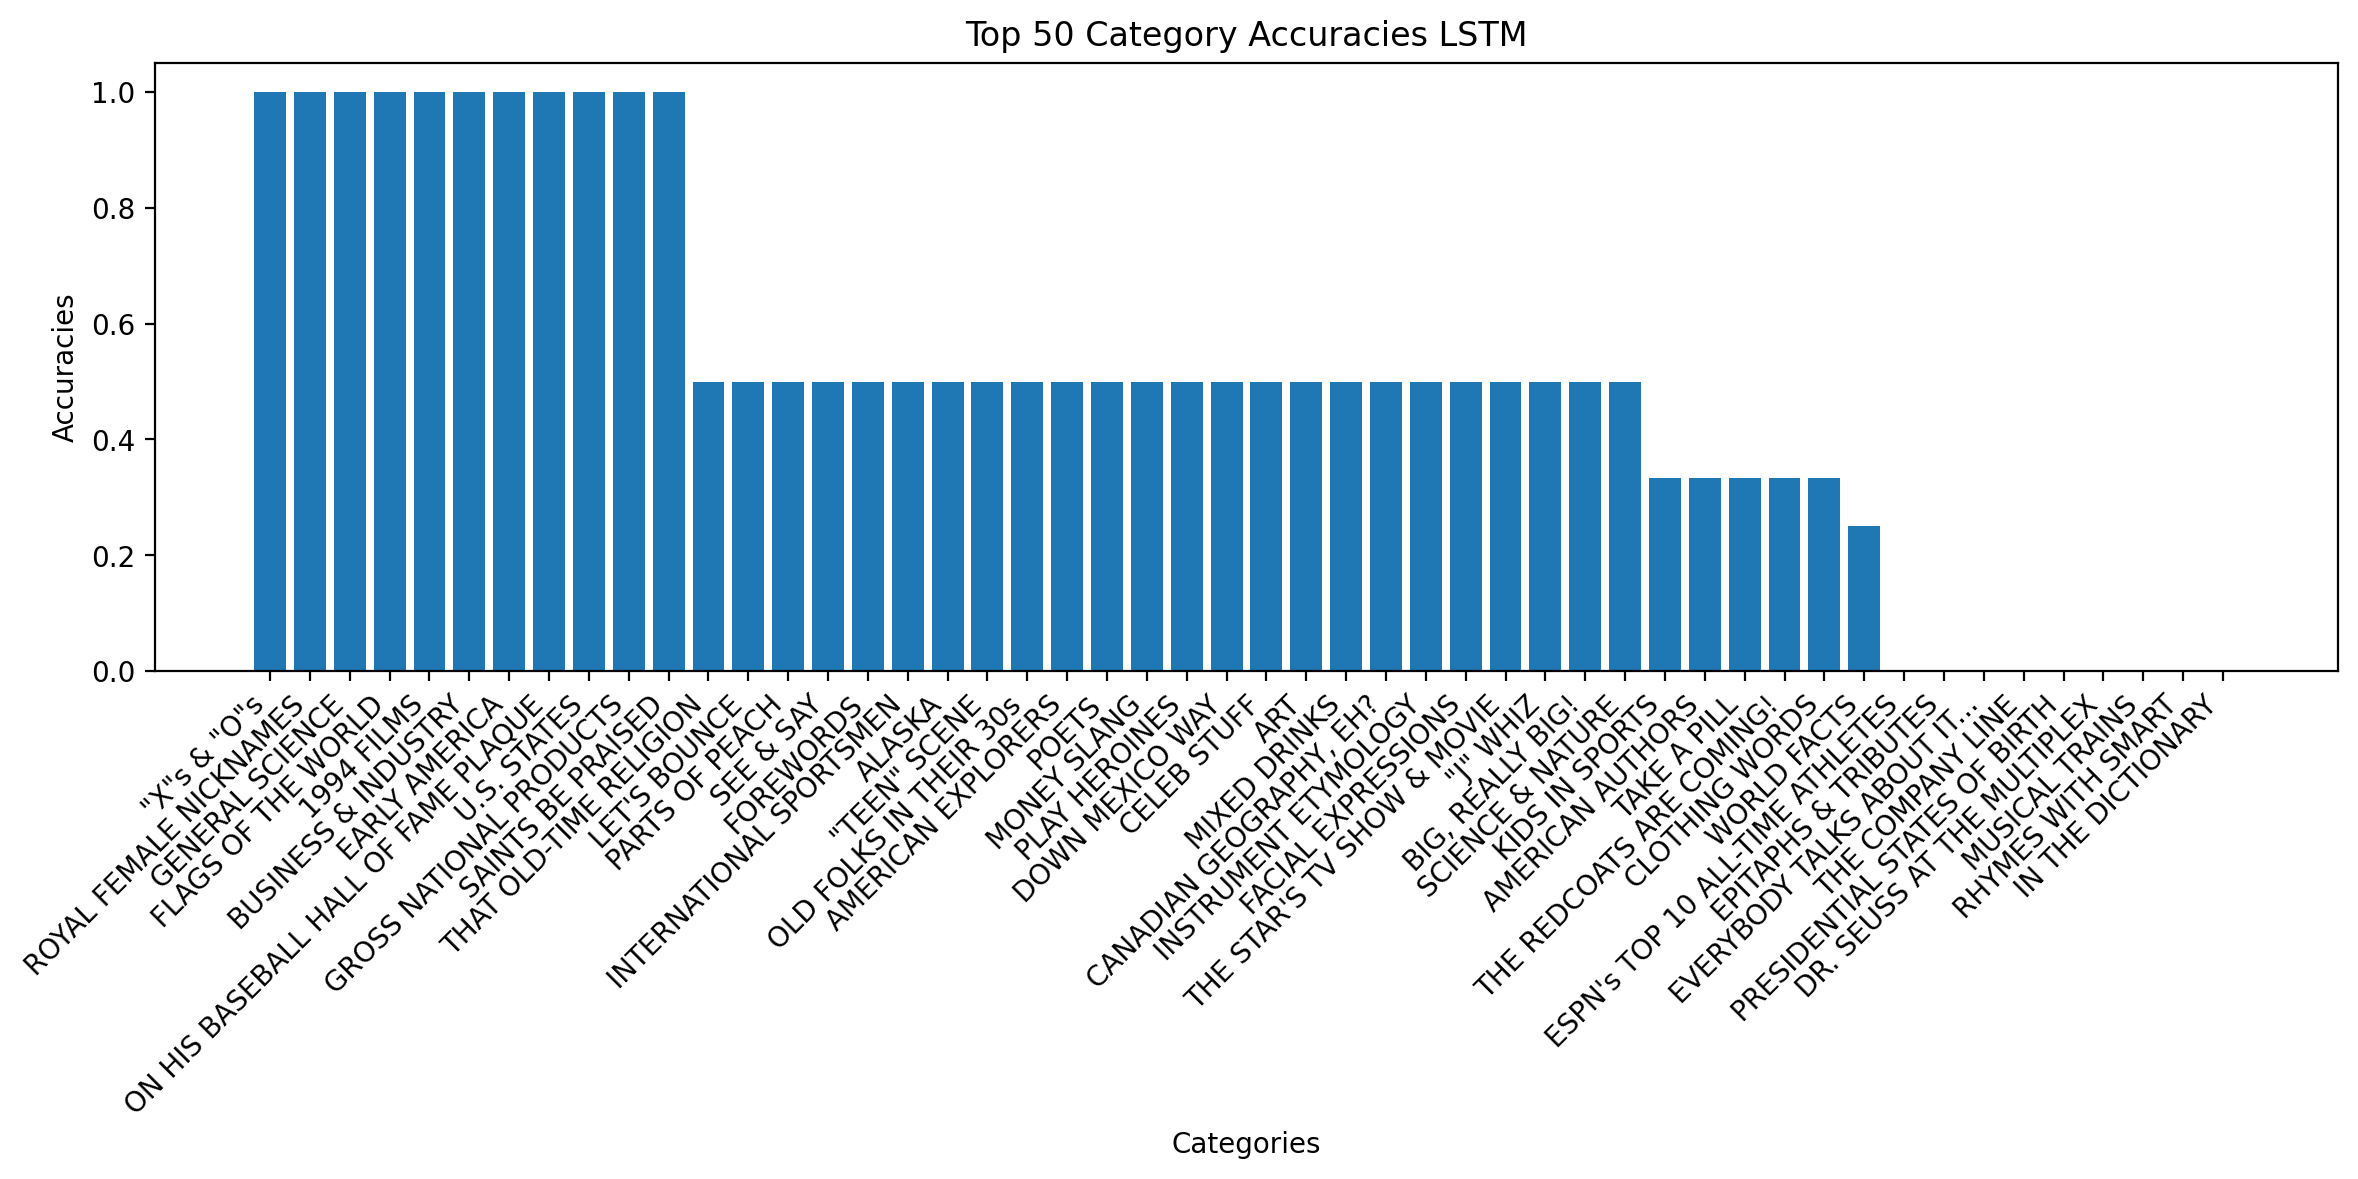

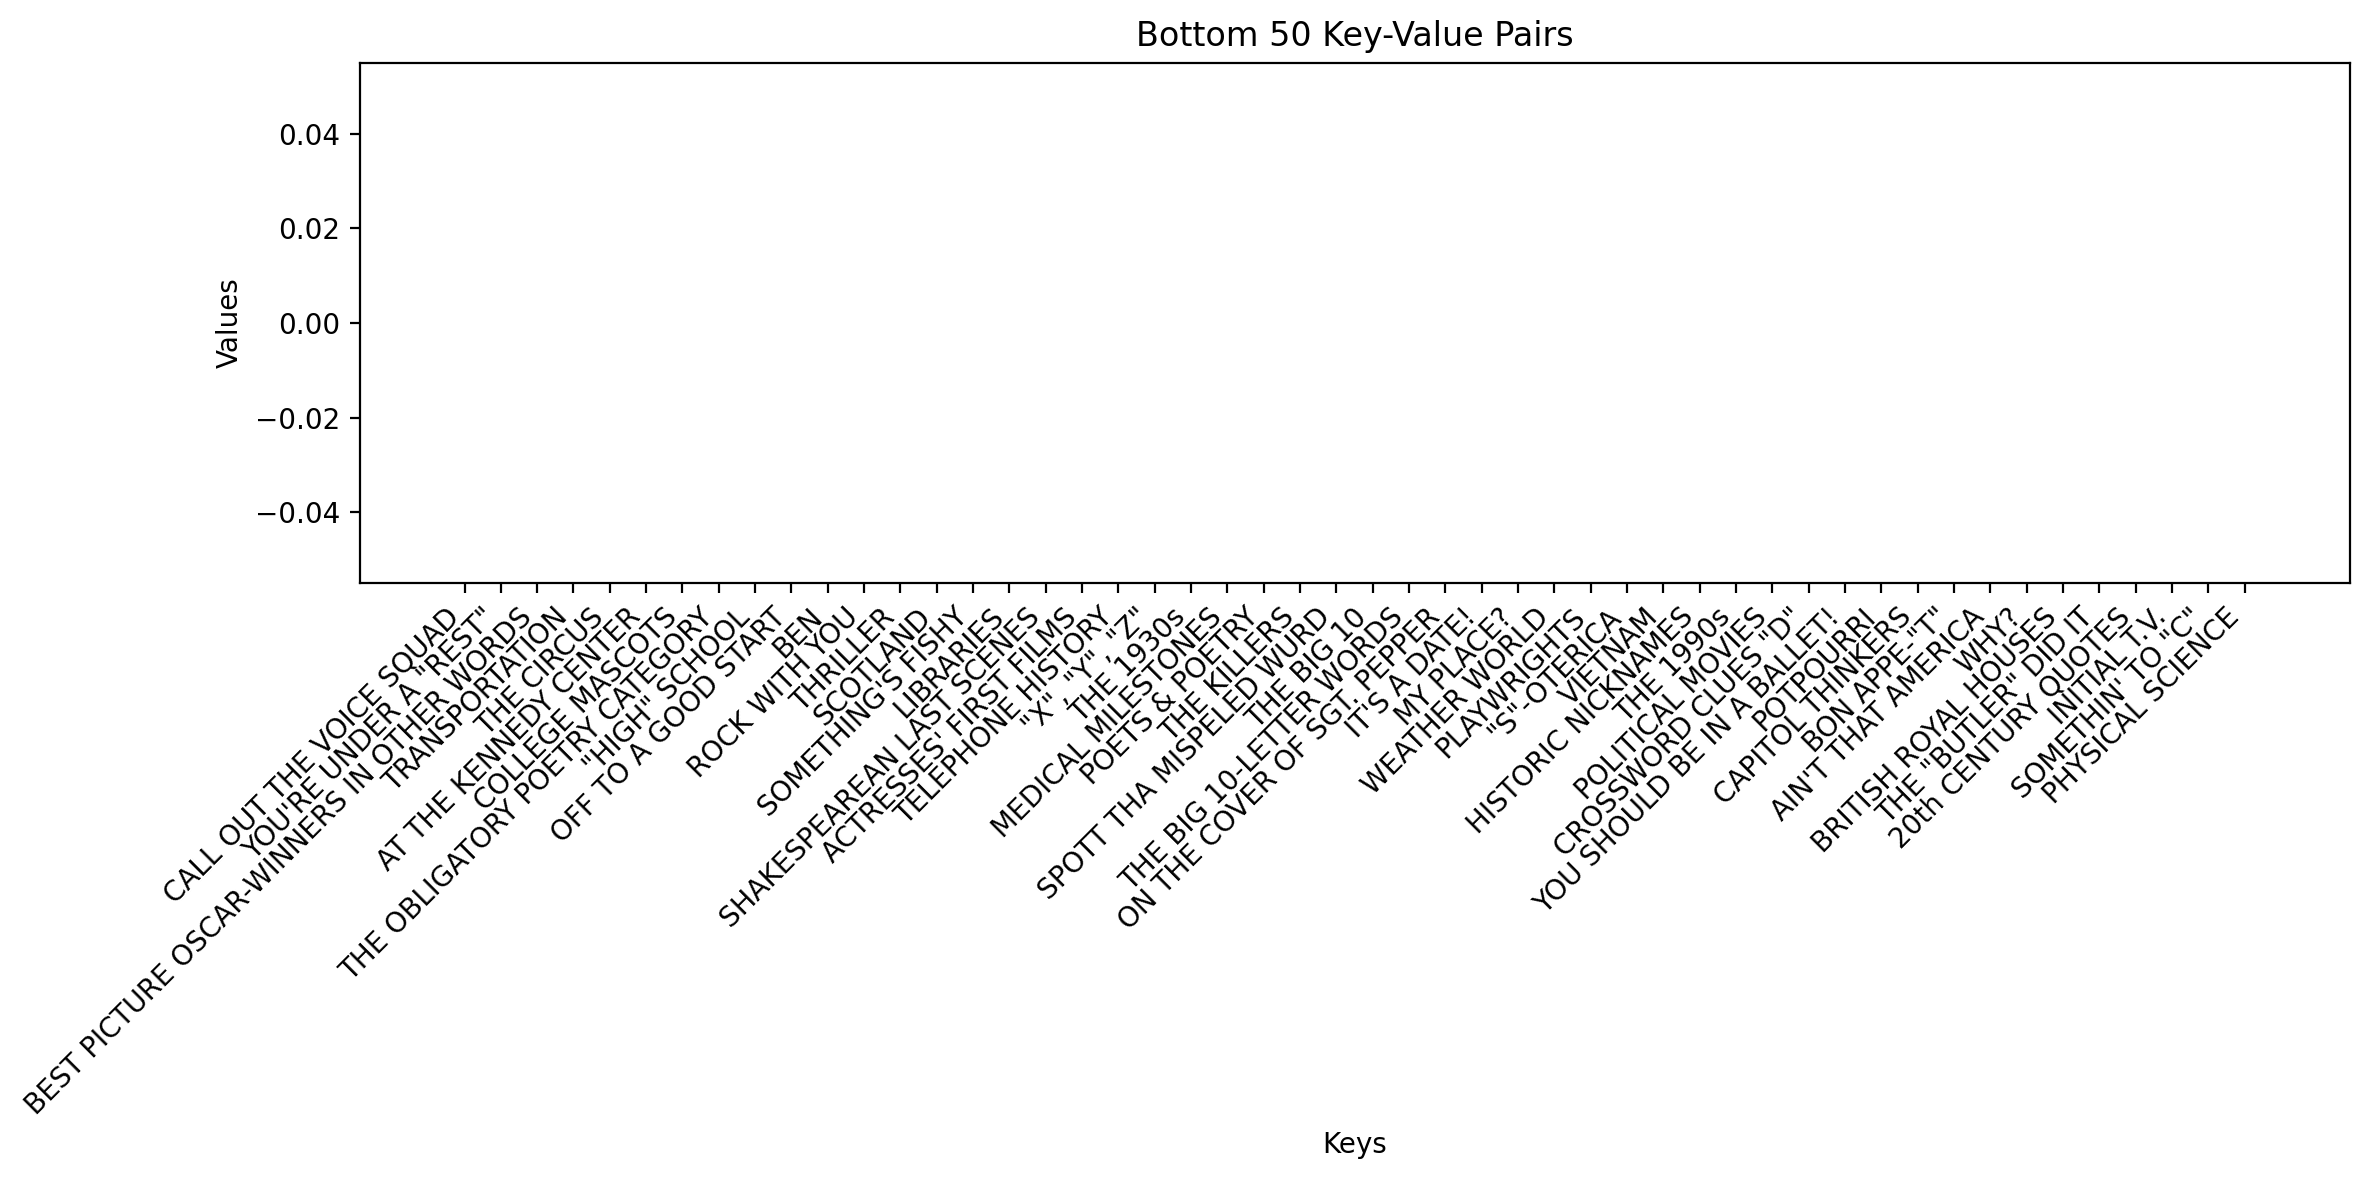

In [30]:
import matplotlib.pyplot as plt

sorted_dict_desc = dict(sorted(category_acc.items(), key=lambda item: item[1], reverse=True))

# Extract top 50 and bottom 50 key-value pairs
top_50 = dict(list(sorted_dict_desc.items())[:50])
bottom_50 = dict(list(sorted_dict_desc.items())[-50:])

# Extract keys and values for plotting
top_keys = list(top_50.keys())
top_values = list(top_50.values())

bottom_keys = list(bottom_50.keys())
bottom_values = list(bottom_50.values())

# Plotting the bar chart for top 50
plt.figure(figsize=(12, 6))
plt.bar(top_keys, top_values)
plt.xlabel('Categories')
plt.ylabel('Accuracies')
plt.title('Top 50 Category Accuracies LSTM')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the bar chart for bottom 50
plt.figure(figsize=(12, 6))
plt.bar(bottom_keys, bottom_values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Bottom 50 Key-Value Pairs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # Sample dictionary

# # Extract keys and values from the dictionary
# keys = list(category_acc.keys())
# values = list(category_acc.values())

# # Plotting the bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(keys, values)
# plt.xlabel('Categories')
# plt.ylabel('Accuracies')
# plt.title('Accuracies per Category')
# plt.show()

{'WORLD FACTS': 4, 'KIDS IN SPORTS': 3, 'FROM THE GREEK': 3, 'AMERICAN AUTHORS': 3, 'TAKE A PILL': 3, 'THE REDCOATS ARE COMING!': 3, 'CLOTHING WORDS': 3, 'THE 1990s': 3, "ESPN's TOP 10 ALL-TIME ATHLETES": 2, 'EPITAPHS & TRIBUTES': 2, 'EVERYBODY TALKS ABOUT IT...': 2, 'THAT OLD-TIME RELIGION': 2, "LET'S BOUNCE": 2, 'PARTS OF PEACH': 2, 'SEE & SAY': 2, 'FOREWORDS': 2, "IT'S OURS!": 2, 'GENERAL SCIENCE': 2, 'INTERNATIONAL SPORTSMEN': 2, 'ALASKA': 2, 'CELEBS': 2, '"TEEN" SCENE': 2, 'OLD FOLKS IN THEIR 30s': 2, 'ALBUMS THAT ROCK': 2, 'MATHEM-ATTACK!': 2, 'AMERICAN EXPLORERS': 2, 'POETS': 2, 'MONEY SLANG': 2, 'PLAY HEROINES': 2, 'BEGINNING & END': 2, 'DOWN MEXICO WAY': 2, 'CELEB STUFF': 2, 'COLLEGE MASCOTS': 2, 'ART': 2, 'THE OBLIGATORY POETRY CATEGORY': 2, '"HIGH" SCHOOL': 2, 'LIBRARIES': 2, 'MIXED DRINKS': 2, 'THE BIG 10': 2, 'CANADIAN GEOGRAPHY, EH?': 2, 'INSTRUMENT ETYMOLOGY': 2, 'FACIAL EXPRESSIONS': 2, "THE STAR'S TV SHOW & MOVIE": 2, 'THE BIG 10-LETTER WORDS': 2, '"J" WHIZ': 2, 'MY PL

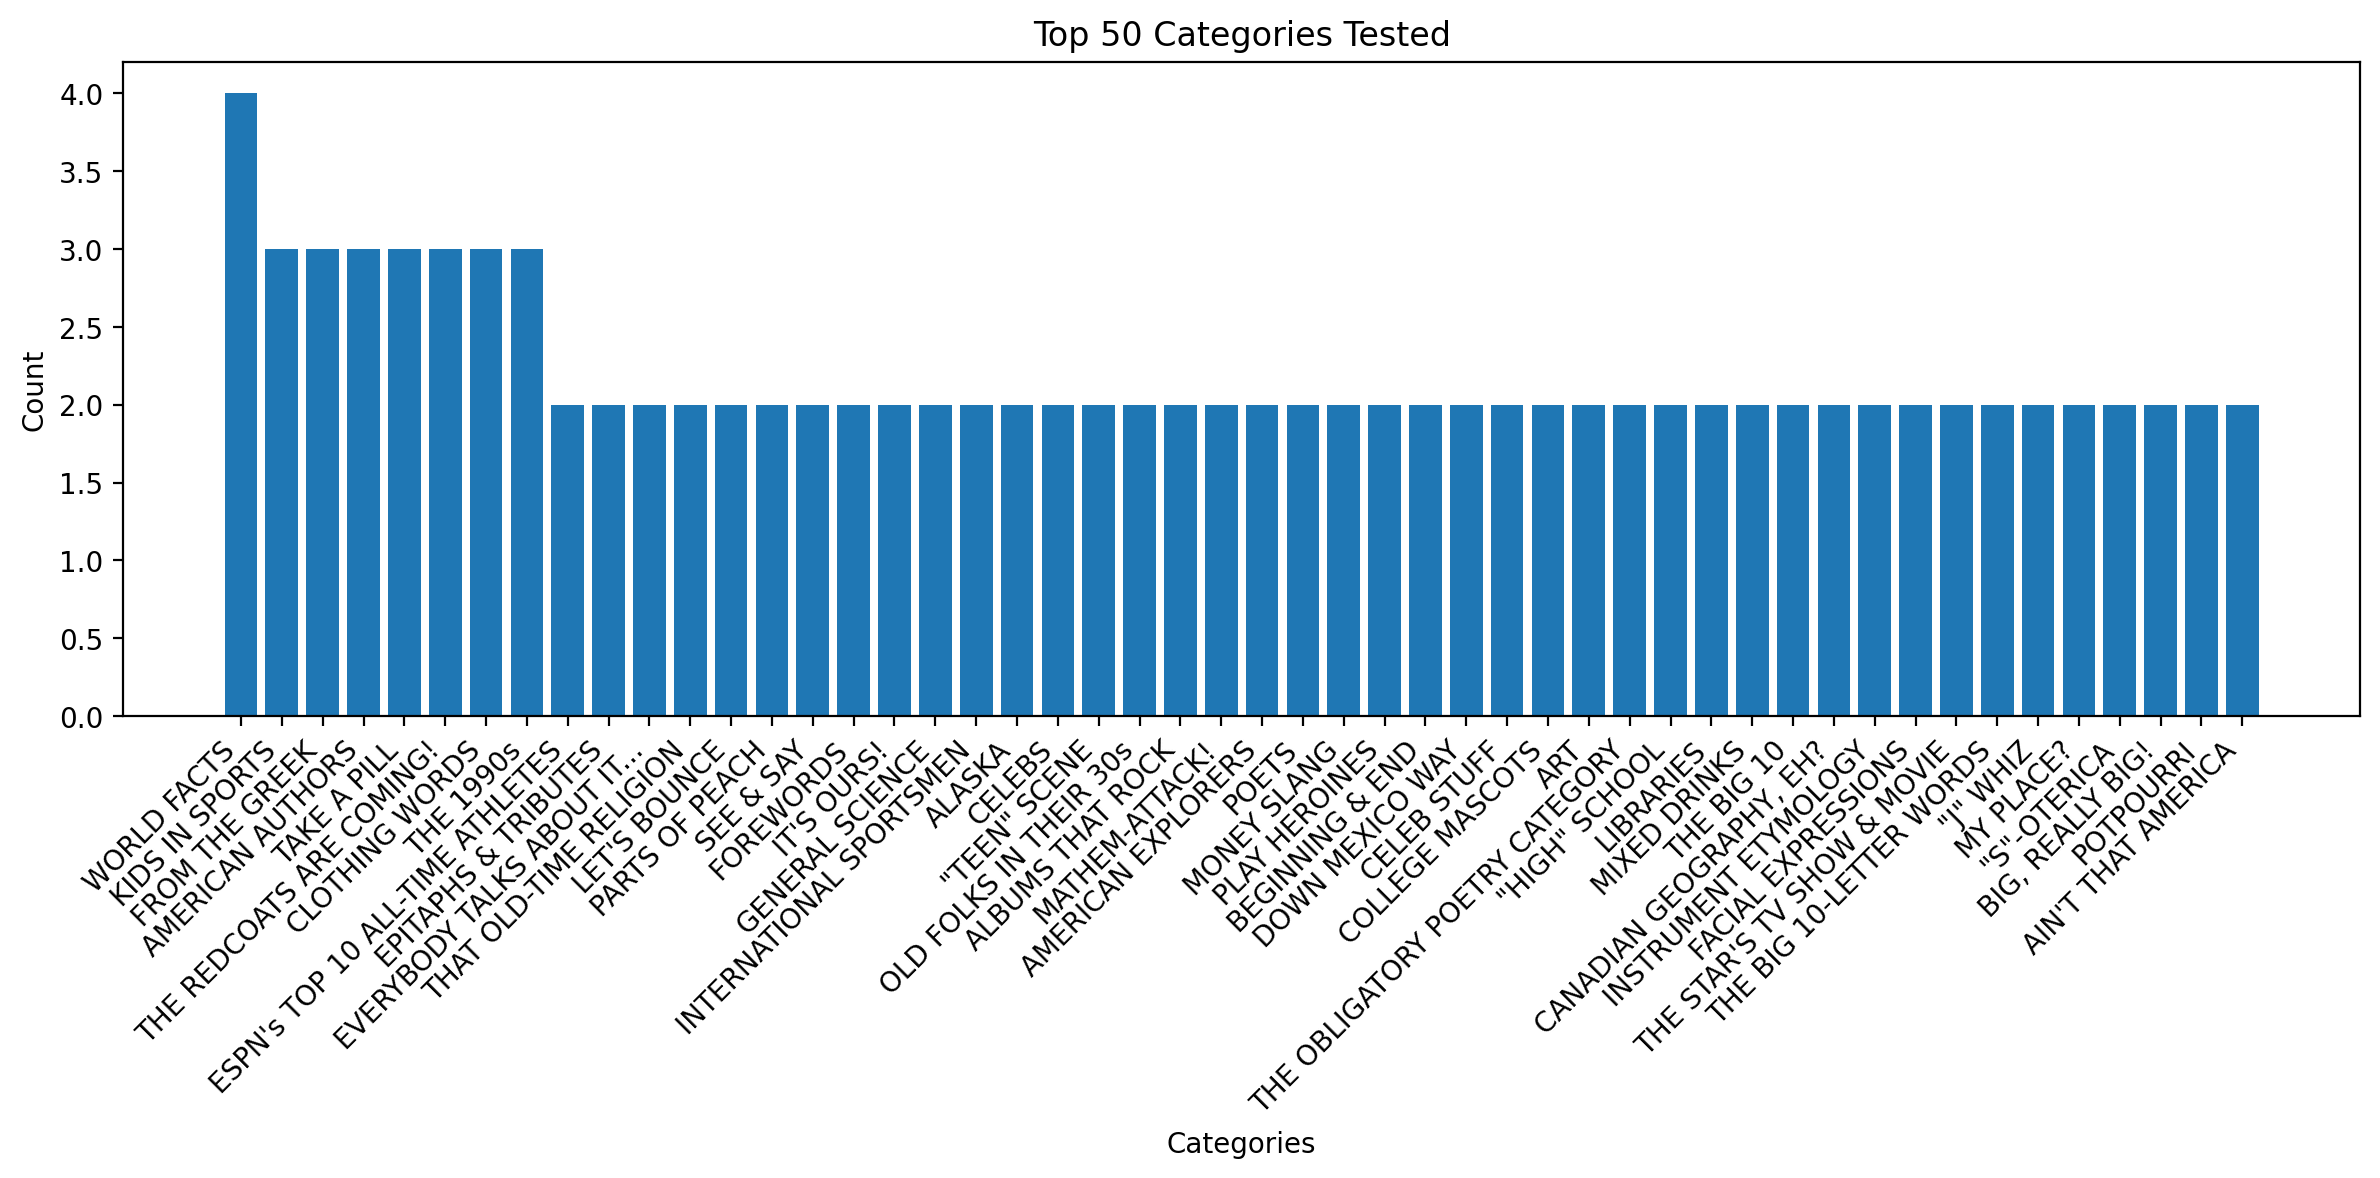

In [49]:
sorted_dict_desc = dict(sorted(category_total_dict.items(), key=lambda item: item[1], reverse=True))

# Extract top 50 and bottom 50 key-value pairs
top_50 = dict(list(sorted_dict_desc.items())[:50])

top_keys = list(top_50.keys())
top_values = list(top_50.values())

print(top_50)

plt.figure(figsize=(12, 6))
plt.bar(top_keys, top_values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Top 50 Categories Tested')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
def category_totals_calc(data_df):
    category_totals = {}
    for index in range(len(data_df)):
        category = data_df.iloc[index][' Category']
        if category not in category_totals:
            category_totals[category] = 0

        category_totals[category] += 1
    return category_totals

category_totals = category_totals_calc(data_df)
    # with torch.no_grad():
    #     index = 0
    #     for i:
    #         #print(inputs)
    #         h = torch.zeros((2, 409,hidden_size))    
    #         c = torch.zeros((2, 409,hidden_size))

    #         outputs, _ = model(inputs, (h.detach(), c.detach()))
    #         # print(outputs)
    #         # print(labels.size(0))
    #         # test_df['Category']
    #         category = test_df.iloc[index][' Category']
    #         predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.
            
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
    #         index += 1

    #         if category not in category_correct_dict:
    #             category_correct_dict[category] = 0
    #             category_total_dict[category] = 0

    #         category_correct_dict[category] += (predicted == labels).sum().item()
    #         category_total_dict[category] += 1

    #         true.append(labels)
    #         pred.append(predicted)
    # acc = (100 * correct / total)
    # print('%s accuracy: %0.3f' % (mode, acc))
    # true = np.concatenate(true)
    # pred = np.concatenate(pred)
    # return category_correct_dict, category_total_dict

{'HISTORY': 10, 'GENERAL SCIENCE': 10, 'AMERICAN AUTHORS': 10, 'MONEY SLANG': 9, "AIN'T THAT AMERICA": 9, "ESPN's TOP 10 ALL-TIME ATHLETES": 5, 'THE COMPANY LINE': 5, 'EPITAPHS & TRIBUTES': 5, '3-LETTER WORDS': 5, 'AIRLINE TRAVEL': 5, 'MUSICAL TRAINS': 5, '"X"s & "O"s': 5, 'GEOGRAPHY "E"': 5, 'RADIO DISNEY': 5, 'PARTS OF PEACH': 5, 'BE FRUITFUL & MULTIPLY': 5, "LET'S BOUNCE": 5, 'RHYMES WITH SMART': 5, 'KIDS IN SPORTS': 5, 'JUST THE FACTS': 5, 'SEE & SAY': 5, 'NEWS TO ME': 5, 'ROYAL FEMALE NICKNAMES': 5, 'TV ACTORS & ROLES': 5, 'TRAVEL & TOURISM': 5, '"I" LADS': 5, 'BACKWORDS': 5, 'PEOPLE IN HISTORY': 5, 'CINEMATIC DICTIONARY': 5, "IT'S OURS!": 5, 'ANDY WARHOL': 5, 'THEATRE CROSSWORD CLUES "M"': 5, 'GETTING POSSESSIVE': 5, 'FLAGS OF THE WORLD': 5, 'ARCHITECTS': 5, '1994 FILMS': 5, 'THE EYES HAVE IT': 5, 'ALASKA': 5, 'INTERNATIONAL SPORTSMEN': 5, 'DRAMA QUEENS': 5, 'ANGELS': 5, 'IN EXILE': 5, 'THE "I"s HAVE IT': 5, 'THE CIVIL WAR': 5, 'CELEBS': 5, "WHAT'S IN A NAME?": 5, 'EMOTICONS': 5,

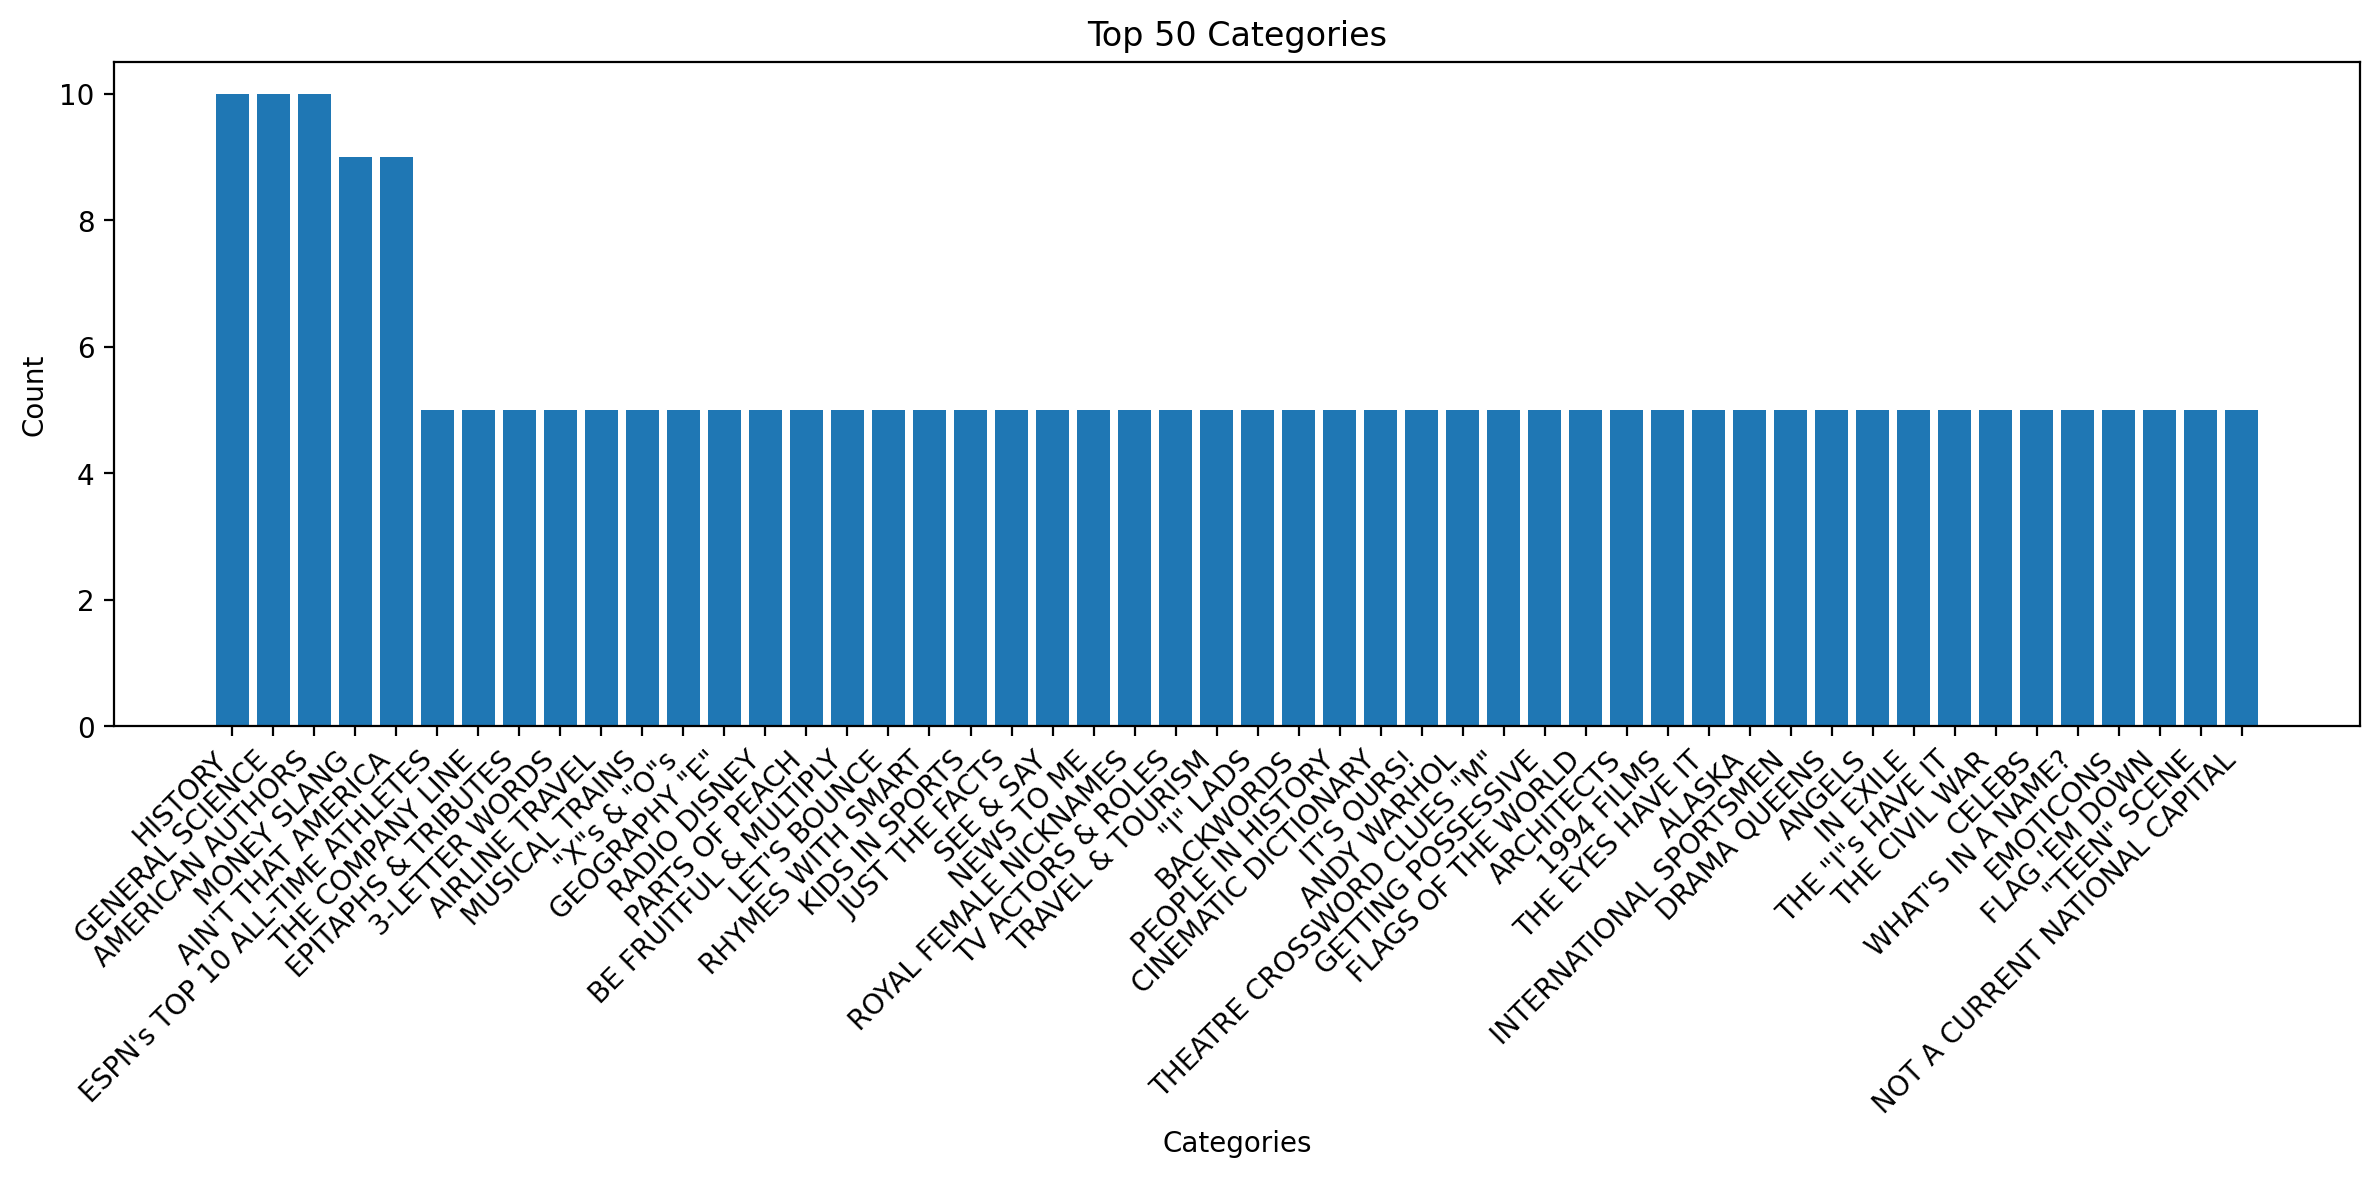

In [40]:
sorted_dict_desc = dict(sorted(category_totals.items(), key=lambda item: item[1], reverse=True))

# Extract top 50 and bottom 50 key-value pairs
top_50 = dict(list(sorted_dict_desc.items())[:50])

top_keys = list(top_50.keys())
top_values = list(top_50.values())

print(top_50)

plt.figure(figsize=(12, 6))
plt.bar(top_keys, top_values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Top 50 Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()